In [1]:
import h5py

import numpy as np
import torch 

import pyvista as pv
import pyvistaqt

pv.set_jupyter_backend('trame')

In [2]:
with h5py.File("/home/dema/Project/GAT/datasets/bifurcating.hdf5", 'r') as f:
    data = {}
    
    # Loop through each sample group
    
    for i, sample in enumerate(f.keys()):
        sample_data = {}
        
        # Extract the datasets (wss, pressure, etc.) for each sample
        sample_data['wss'] = np.array(f[sample]['wss'])
        sample_data['pressure'] = np.array(f[sample]['pressure'])
        sample_data['pos'] = np.array(f[sample]['pos'])
        sample_data['face'] = np.array(f[sample]['face'])
        sample_data['inlet_idcs'] = np.array(f[sample]['inlet_idcs'])
        
        # Store the sample data in the dictionary
        data[i] = sample_data


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/dema/Project/GAT/datasets/bifurcating.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:
data[0].keys()

dict_keys(['wss', 'pressure', 'pos', 'face', 'inlet_idcs'])

In [6]:
print(data[1]['wss'].shape)
print(data[1]['pressure'].shape)
print(data[1]['pos'].shape)
print(data[1]['face'].shape)
print(data[1]['inlet_idcs'].shape)
print(data[1]['inlet_idcs'].dtype)

(19720, 3)
(19720,)
(19720, 3)
(39436, 3)
(966,)
int32


In [7]:
x = data[0]
face = x['face']
pos = x['pos']

In [8]:
triangle = (torch.ones(face.shape[0], dtype=torch.int32)*3).reshape(-1, 1)
face_T = torch.Tensor(face)
triangle.shape, face_T.shape

(torch.Size([38430, 1]), torch.Size([38430, 3]))

In [9]:
face_T_mesh = torch.concat((triangle, face_T), dim=-1)
face_T_mesh = face_T_mesh.to(torch.int32)
colors = torch.ones(pos.shape[0])
colors[x['inlet_idcs']] = 0


In [10]:
mesh = pv.PolyData(pos, face_T_mesh)
mesh.point_data["Inlet"] = colors

plotter = pv.Plotter()
plotter.add_mesh(mesh, scalars="Inlet", show_edges=True)
plotter.show()


Widget(value='<iframe src="http://localhost:39251/index.html?ui=P_0x738d7a1188b0_0&reconnect=auto" class="pyvi…

Generic multivector: 
/-----------------
0 :  scalar
/-----------------  
[ VECTOR ] 

1: e0 ---> is this the element that squared return 0?
2: e1 ---> classical basis 1
3: e2 ---> classical basis 2
4: e3 ---> classical basis 3

/----------------
[ BIVECTOR ]

5:  e 01
6:  e 02
7:  e 03
8:  e 12
9:  e 31
10: e 23

/--------------
[ TRIVECTOR ]
11: e_021
12: e_013
13: e_032
14: e_123
/-------------
[ PSEUDOSCALAR] 
15: e_0123


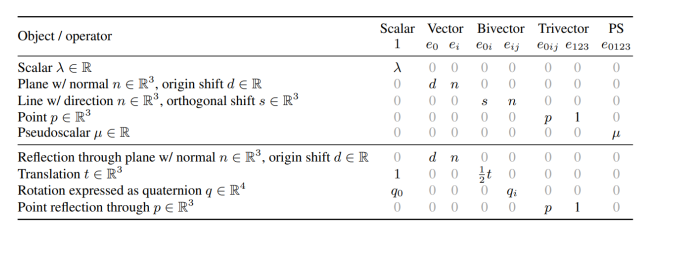  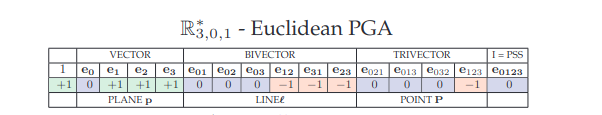